# Data Science Salaries 2023

Le but de cette analyse est de prédire le salaire des métiers de la Data Science. [Le dataset peut se trouver ici](https://www.kaggle.com/datasets/arnabchaki/data-science-salaries-2023?datasetId=3125926&sortBy=voteCount) et s'appuie sur le travail de [cette personne](https://www.kaggle.com/code/tumpanjawat/ds-salary-full-eda-geo-cluster-xgboost)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline

### 1) Data quality

In [2]:
data = pd.read_csv('ds_salaries.csv')
data['experience_level'] = data['experience_level'].replace({
    'SE': 'Senior',
    'EN': 'Entry level',
    'EX': 'Executive level',
    'MI': 'Mid/Intermediate level',
})

data['employment_type'] = data['employment_type'].replace({
    'FL': 'Freelancer',
    'CT': 'Contractor',
    'FT' : 'Full-time',
    'PT' : 'Part-time'
})
data['company_size'] = data['company_size'].replace({
    'S': 'SMALL',
    'M': 'MEDIUM',
    'L' : 'LARGE',
})
data['remote_ratio'] = data['remote_ratio'].astype(str)
data['remote_ratio'] = data['remote_ratio'].replace({
    '0': 'On-Site',
    '50': 'Half-Remote',
    '100' : 'Full-Remote',
})

def assign_broader_category(job_title):
    data_engineering = ["Data Engineer", "Data Analyst", "Analytics Engineer", "BI Data Analyst", "Business Data Analyst", "BI Developer", "BI Analyst", "Business Intelligence Engineer", "BI Data Engineer", "Power BI Developer"]
    data_scientist = ["Data Scientist", "Applied Scientist", "Research Scientist", "3D Computer Vision Researcher", "Deep Learning Researcher", "AI/Computer Vision Engineer"]
    machine_learning = ["Machine Learning Engineer", "ML Engineer", "Lead Machine Learning Engineer", "Principal Machine Learning Engineer"]
    data_architecture = ["Data Architect", "Big Data Architect", "Cloud Data Architect", "Principal Data Architect"]
    management = ["Data Science Manager", "Director of Data Science", "Head of Data Science", "Data Scientist Lead", "Head of Machine Learning", "Manager Data Management", "Data Analytics Manager"]
    
    if job_title in data_engineering:
        return "Data Engineering"
    elif job_title in data_scientist:
        return "Data Science"
    elif job_title in machine_learning:
        return "Machine Learning"
    elif job_title in data_architecture:
        return "Data Architecture"
    elif job_title in management:
        return "Management"
    else:
        return "Other"

# Apply the function to the 'job_title' column and create a new column 'job_category'
data['job_category'] = data['job_title'].apply(assign_broader_category)

data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_category
0,2023,Senior,Full-time,Principal Data Scientist,80000,EUR,85847,ES,Full-Remote,ES,LARGE,Other
1,2023,Mid/Intermediate level,Contractor,ML Engineer,30000,USD,30000,US,Full-Remote,US,SMALL,Machine Learning
2,2023,Mid/Intermediate level,Contractor,ML Engineer,25500,USD,25500,US,Full-Remote,US,SMALL,Machine Learning
3,2023,Senior,Full-time,Data Scientist,175000,USD,175000,CA,Full-Remote,CA,MEDIUM,Data Science
4,2023,Senior,Full-time,Data Scientist,120000,USD,120000,CA,Full-Remote,CA,MEDIUM,Data Science


### 2) Analyse des données


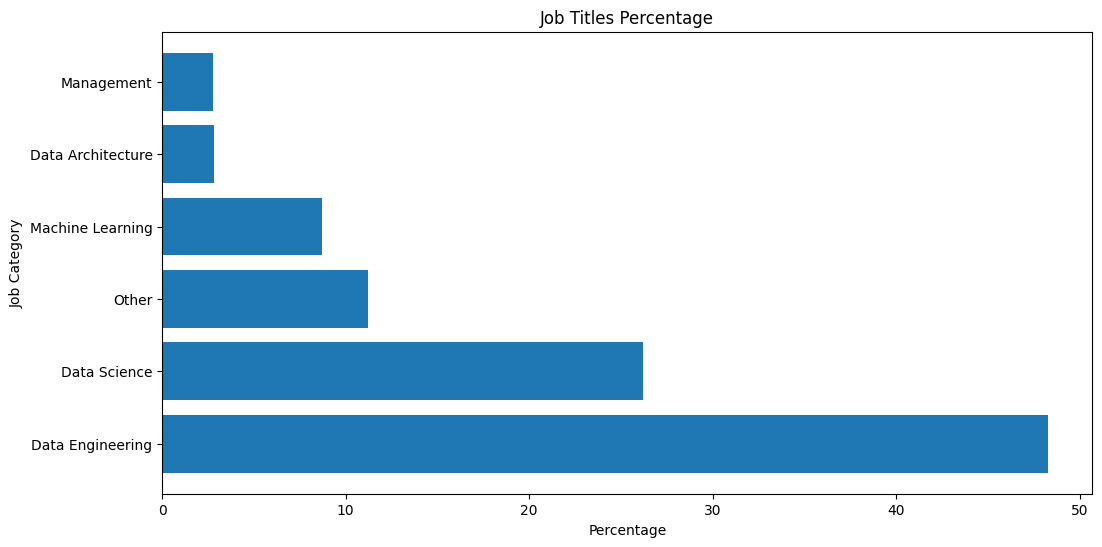

In [3]:
value_counts = data['job_category'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(12, 6))
top_n = min(17, len(value_counts))
ax.barh(value_counts.index[:top_n], value_counts.values[:top_n])
ax.set_xlabel('Percentage')
ax.set_ylabel('Job Category')
ax.set_title('Job Titles Percentage')
plt.show()

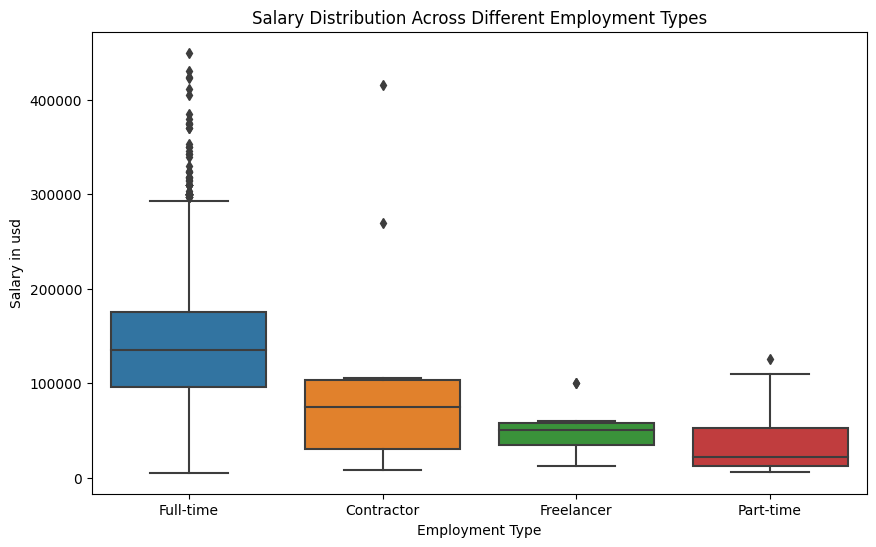

In [4]:
# Salary distribution across different employment types
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='employment_type', y='salary_in_usd')
plt.title('Salary Distribution Across Different Employment Types')
plt.xlabel('Employment Type')
plt.ylabel('Salary in usd')
plt.show()

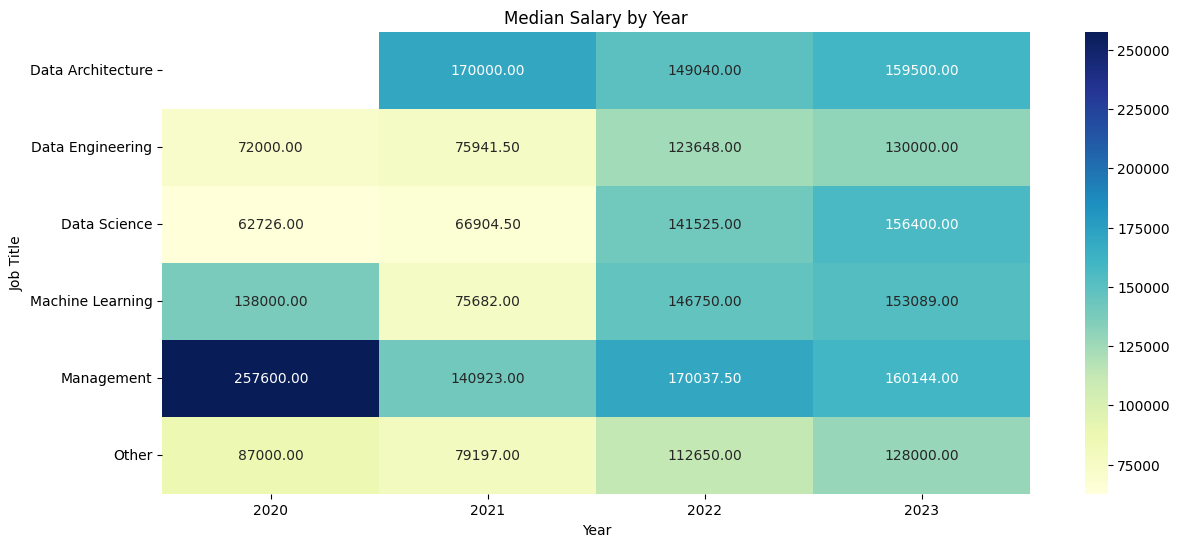

In [5]:
df = data.copy()

#  Median salary by job title
pivot_table = df.pivot_table(values='salary_in_usd', index='job_category', columns='work_year', aggfunc='median')
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Median Salary by Year')
plt.xlabel('Year')
plt.ylabel('Job Title')
plt.show()

### 3) Corrélation

In [6]:
categorical_columns = ['experience_level', 'employment_type', 'remote_ratio','company_size','job_category']
numerical_columns = ['salary_in_usd']

In [7]:
dummy_variables = pd.get_dummies(df, columns=categorical_columns, drop_first=False)

In [8]:
df.head(5)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_category
0,2023,Senior,Full-time,Principal Data Scientist,80000,EUR,85847,ES,Full-Remote,ES,LARGE,Other
1,2023,Mid/Intermediate level,Contractor,ML Engineer,30000,USD,30000,US,Full-Remote,US,SMALL,Machine Learning
2,2023,Mid/Intermediate level,Contractor,ML Engineer,25500,USD,25500,US,Full-Remote,US,SMALL,Machine Learning
3,2023,Senior,Full-time,Data Scientist,175000,USD,175000,CA,Full-Remote,CA,MEDIUM,Data Science
4,2023,Senior,Full-time,Data Scientist,120000,USD,120000,CA,Full-Remote,CA,MEDIUM,Data Science


Pour le preprocessing de nos données, nous standardisons nos valeurs numériques afin d'avoir potentiellement des meilleurs résultats et les catégories sont encodées par le One-hot encoding afin que notre modèle puisse comprendre les données.

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Scale the numerical columns
scaled_numerical = scaler.fit_transform(df[numerical_columns])

# Convert the scaled numerical columns
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_columns)

# Drop the original numerical columns
dummy_variables = dummy_variables.drop(numerical_columns, axis=1)

# Concatenate the dummy variables and scaled numerical columns
processed_df = pd.concat([dummy_variables, scaled_numerical_df], axis=1)
processed_df = processed_df.drop(['work_year', 'salary', 'job_title', 'salary_currency',
                                  'salary', 'employee_residence', 'company_location'], axis=1)

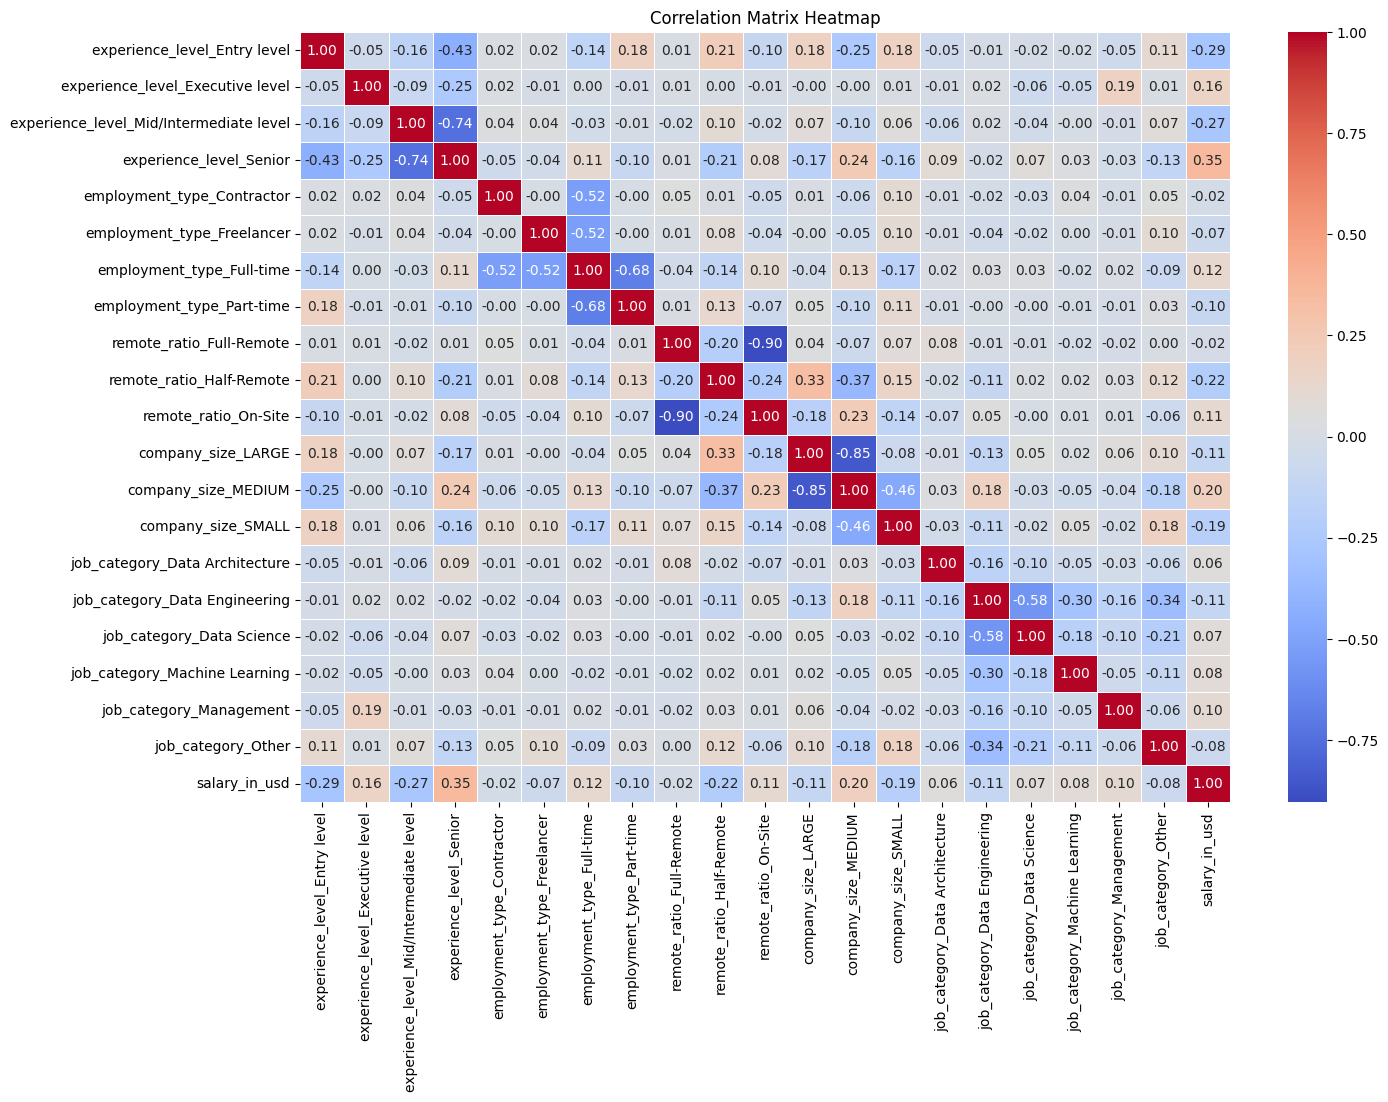

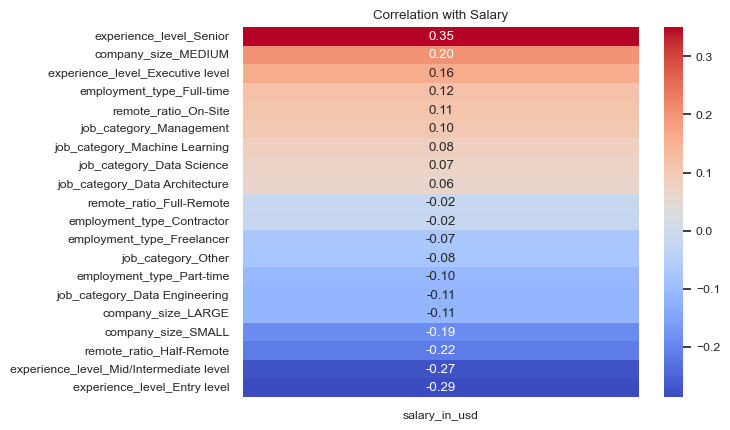

In [10]:
correlation_matrix = processed_df.corr()

#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

corr = processed_df.corr()
target_corr = corr['salary_in_usd'].drop('salary_in_usd')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

#Graph II
# Create a heatmap of the correlations with the target column
sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Salary')
plt.show()

### Prédiction de salaire

Nous allons choisir les catégories les plus importantes pour ensuite prédire, parmis 7 catégories, le salaire d'un individu en se basant sur ses caractéristiques.

In [11]:
df = data.copy()
df = df.drop(['work_year','salary','salary_currency','job_title'], axis=1)
df.head()

,experience_level,employment_type,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_category
0,Senior,Full-time,85847,ES,Full-Remote,ES,LARGE,Other
1,Mid/Intermediate level,Contractor,30000,US,Full-Remote,US,SMALL,Machine Learning
2,Mid/Intermediate level,Contractor,25500,US,Full-Remote,US,SMALL,Machine Learning
3,Senior,Full-time,175000,CA,Full-Remote,CA,MEDIUM,Data Science
4,Senior,Full-time,120000,CA,Full-Remote,CA,MEDIUM,Data Science


On retire les données aberrantes

In [12]:
# Outlier detection using IQR method
salary = df.select_dtypes(include=[np.number])
Q1 = salary.quantile(0.25, numeric_only=True)
Q3 = salary.quantile(0.75, numeric_only=True)
IQR = Q3 - Q1
df = df[~((salary < (Q1 - 1.5 * IQR)) | (salary > (Q3 + 1.5 * IQR))).any(axis=1)]

### Séparation des salaires en 7 catégories

In [13]:
# Calculate quantiles for salary bin edges
quantiles = [0, 1/7, 2/7, 3/7, 4/7, 5/7, 6/7, 1]
bin_edges = [df['salary_in_usd'].quantile(q) for q in quantiles]

# Convert the continuous salary variable into 7 discrete bins based on quantiles
salary_labels = ['low', 'low-mid', 'mid', 'mid-high', 'high', 'very-high', 'Top']
df.loc[:, 'salary_range'] = pd.cut(df['salary_in_usd'], bins=bin_edges, labels=salary_labels, include_lowest=True)

### Preprocessing

In [14]:
# Label encoding for categorical features
encoder = LabelEncoder()
categorical_features = ['employment_type', 'job_category', 'experience_level', 
                        'employee_residence', 'remote_ratio', 'company_location', 'company_size']
for feature in categorical_features:
    df.loc[:, feature] = encoder.fit_transform(df[feature])
# Split the dataset into training and testing sets
X = df.drop(["salary_in_usd", "salary_range"], axis=1)
y = df["salary_range"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Training et validation

In [15]:
# Define the models
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('KNN', KNeighborsClassifier())
]

# Model training, evaluation, and selection
best_model = None
best_score = -np.inf

print("Model performance:")
for name, model in models:
    pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"{name} - Accuracy: {accuracy:.2f}")
    
    if accuracy > best_score:
        best_score = accuracy
        best_model = pipeline

print(f"Best model: {best_model.named_steps['model']} with accuracy: {best_score:.2f}")

Model performance:
Logistic Regression - Accuracy: 0.25
Random Forest - Accuracy: 0.28
Gradient Boosting - Accuracy: 0.29
KNN - Accuracy: 0.26
Best model: GradientBoostingClassifier() with accuracy: 0.29


### Model tuning

GradientBoostingClassifier et RandomForestClassifier sont des algorithmes d’apprentissage supervisés qui utilisent un ensemble d’arbres de décision pour prédire la classe d’un objet. Leur but pour la classification est de combiner les prédictions de plusieurs arbres de décision pour obtenir une prédiction plus précise.

Voici les principaux hyperparamètres des deux méthodes:

n_estimators : Nombre d’étapes à effectuer.  
max_depth : Profondeur maximale de l’arbre.  
min_samples_split : Nombre minimum d’échantillons requis pour diviser un nœud interne.  
min_samples_leaf : Nombre minimum d’échantillons requis pour être au niveau d’un nœud feuille.  

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid)
grid.fit(X_train, y_train)

best_accuracy = grid.score(X_test, y_test)
print(f'Best hyperparameters: {grid.best_params_}')
print(f'Accuracy of best model: {best_accuracy:.2f}')

Best hyperparameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10}
Accuracy of best model: 0.30


In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 10],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4]
}

grid = GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid)
grid.fit(X_train, y_train)
best_accuracy = grid.score(X_test, y_test)

print(f'Best hyperparameters: {grid.best_params_}')
print(f'Accuracy of best model: {best_accuracy:.2f}')

Best hyperparameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}
Accuracy of best model: 0.29


La recherche d'hypermaramètre et la cross-validation ne semble pas améliorer notre modèle.  
Nous obtenons ainsi une précision moyenne de 0.30, ce qui est assez faible.  

Plusieurs améliorations peuvent être faites, par exemple en créeant d'autres catégories qui permettent d'avoir plus de lien entre les autres catégories ou en retirant certaines catégories qui ne sont pas forcément pertinentes 